In [556]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import plotly.express as ex
import plotly.offline as pyo
import plotly.graph_objects as go

import scipy.stats
from imblearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2, RFE, RFECV, SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, plot_confusion_matrix, roc_curve, roc_auc_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.under_sampling import NearMiss, TomekLinks

import joblib

In [4]:
df = pd.read_csv('bank-full.csv',';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.drop(columns='day month poutcome'.split(), inplace=True)

In [6]:
df['y'] = np.where(df['y']=='no', 0, 1)

In [7]:
X = df.drop(columns='y')
y = df.y

In [328]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,stratify=y, random_state=8, test_size=.2)

In [17]:
education_mapping=[
    {'col': 0,
     'mapping': {'primary': 1, 'secondary': 2, 'tertiary': 3}}
]

### __Random Forest__

In [410]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
# numerical_pipeline = Pipeline([
#     ('minmax_scaler', MinMaxScaler())
#     ('poly', PolynomialFeatures(3, include_bias=False))
# ])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan'])
#     ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc_rfe = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc_rfe, n_features_to_select = 10, step=1)
rfc_clf = RandomForestClassifier(random_state=8)

rfc_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', rfc_clf)
])

In [411]:
model_default_rfc = rfc_pipeline.fit(X_train, y_train)
y_pred_default_rfc = model_default_rfc.predict(X_test)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [412]:
print(classification_report(y_test, y_pred_default_rfc))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7985
           1       0.53      0.43      0.47      1058

    accuracy                           0.89      9043
   macro avg       0.73      0.69      0.71      9043
weighted avg       0.88      0.89      0.88      9043



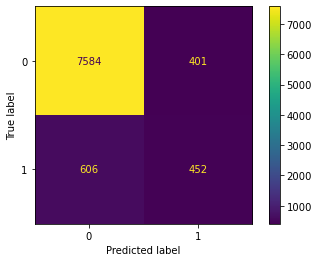

In [413]:
plot_confusion_matrix(rfc_pipeline,
                     X_test,
                     y_test)

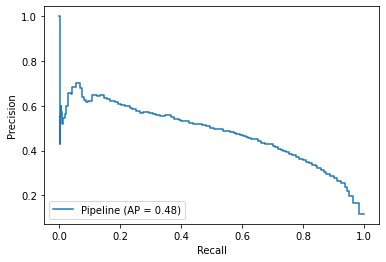

In [414]:
plot_precision_recall_curve(model_default_rfc, X_test, y_test)

In [415]:
rfc_default_cv = cross_val_score(rfc_pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='recall')

In [416]:
print('Mean of Random Forest Benchmark Model Recall Score: ', rfc_default_cv.mean())

Mean of Random Forest Benchmark Model Recall Score:  0.41928346744594325


In [417]:
hyperparam_space_rfc = {
    'clf__max_depth': [2,3,4,5,6,7],
    'clf__min_samples_split': [4,5,6,7,8,9,10],
    'clf__max_features': [7,8,9,10,11],
    'clf__criterion': ['entropy', 'gini']
}

grid_search_rfc = GridSearchCV(rfc_pipeline, hyperparam_space_rfc, scoring='recall', n_jobs=-1, cv=2, verbose=1)

In [418]:
grid_search_rfc.fit(X_train, y_train)

Fitting 2 folds for each of 420 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 71.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 181.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 329.1min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed: 350.5min finished
D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mode_onehot_pipe',
                                                                         Pipeline(steps=[('mode_impute_cat',
                                                                                          SimpleImputer(missing_values='unknown',
                                                                                                        strategy='most_frequent')),
                                                                                         ('mode_onehot',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['job']),
                                                                     

#### __E. Hyperparameter Tuning Evaluation__

In [419]:
print('best score', grid_search_rfc.best_score_)
print('best params', grid_search_rfc.best_params_)

best score 0.776177787609433
best params {'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__max_features': 9, 'clf__min_samples_split': 4}


In [420]:
cv_result_rfc = pd.DataFrame(grid_search_rfc.cv_results_)
cv_result_rfc.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__max_features,param_clf__min_samples_split,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,191.578207,3.510747,0.561677,0.066961,entropy,2,7,4,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.728132,0.705577,0.716854,0.011278,141
1,199.017947,1.331489,0.593158,0.062463,entropy,2,7,5,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.728132,0.705577,0.716854,0.011278,141
2,175.813017,2.562522,0.654123,0.088449,entropy,2,7,6,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.728132,0.705577,0.716854,0.011278,141
3,170.038846,0.052469,0.526696,0.018990,entropy,2,7,7,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.728132,0.705577,0.716854,0.011278,141
4,177.032846,8.316431,0.535191,0.056466,entropy,2,7,8,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.728132,0.705577,0.716854,0.011278,141


In [431]:
mts_list_rfc_criterion = []

for elm in cv_result_rfc['param_clf__criterion'].unique():
    mean_elm = cv_result_rfc[cv_result_rfc['param_clf__criterion']==elm]['mean_test_score'].mean()
    mts_list_rfc_criterion.append(mean_elm)

In [432]:
mts_list_rfc_max_depth = []

for elm in cv_result_rfc['param_clf__max_depth'].unique():
    mean_elm = cv_result_rfc[cv_result_rfc['param_clf__max_depth']==elm]['mean_test_score'].mean()
    mts_list_rfc_max_depth.append(mean_elm)

In [433]:
mts_list_rfc_max_features = []

for elm in cv_result_rfc['param_clf__max_features'].unique():
    mean_elm = cv_result_rfc[cv_result_rfc['param_clf__max_features']==elm]['mean_test_score'].mean()
    mts_list_rfc_max_features.append(mean_elm)

In [434]:
mts_list_rfc_min_samples_split = []

for elm in cv_result_rfc['param_clf__min_samples_split'].unique():
    mean_elm = cv_result_rfc[cv_result_rfc['param_clf__min_samples_split']==elm]['mean_test_score'].mean()
    mts_list_rfc_min_samples_split.append(mean_elm)

In [436]:
criterion_rfc_df = pd.DataFrame({'criterion':cv_result_rfc['param_clf__criterion'].unique(),
                                  'test_score':mts_list_rfc_criterion})

In [437]:
max_depth_rfc_df = pd.DataFrame({'max_depth':cv_result_rfc['param_clf__max_depth'].unique(),
                                  'test_score':mts_list_rfc_max_depth})

In [438]:
max_features_rfc_df = pd.DataFrame({'max_features':cv_result_rfc['param_clf__max_features'].unique(),
                                  'test_score':mts_list_rfc_max_features})

In [439]:
min_samples_split_df = pd.DataFrame({'min_samples_split':cv_result_rfc['param_clf__min_samples_split'].unique(),
                                  'test_score':mts_list_rfc_min_samples_split})

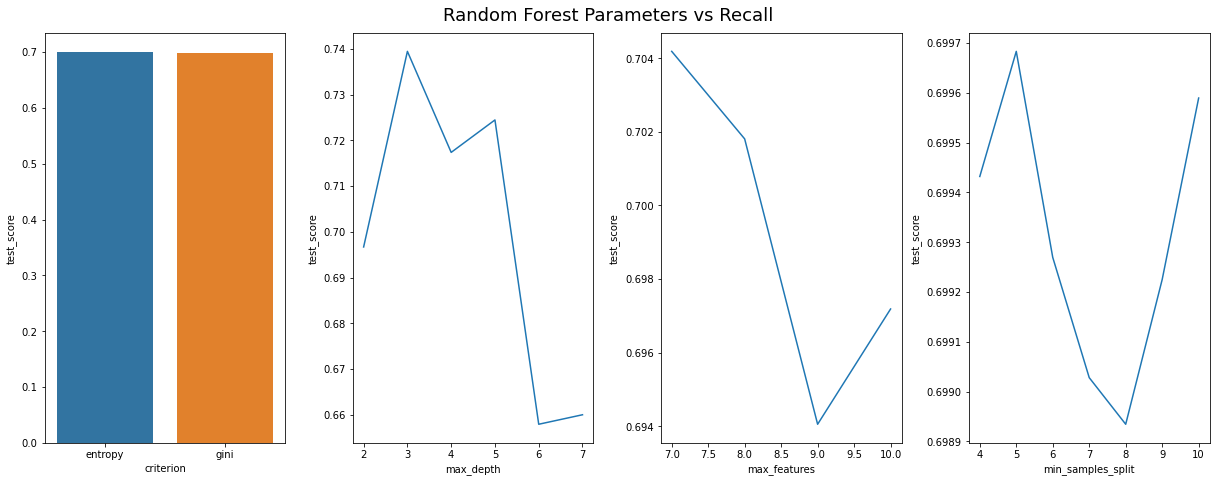

In [446]:
fig, ax = plt.subplots(1,4,figsize=(17,7))
plt.suptitle("Random Forest Parameters vs Recall", size=18)

sns.barplot(data=criterion_rfc_df, x='criterion', y='test_score', ax=ax[0])
sns.lineplot(data=max_depth_rfc_df, x='max_depth', y='test_score', ax=ax[1])
sns.lineplot(data=max_features_rfc_df, x='max_features', y='test_score', ax=ax[2])
sns.lineplot(data=min_samples_split_df, x='min_samples_split', y='test_score', ax=ax[3])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### __F. Comparing Benchmark Model with Tuned Model__

In [447]:
grid_search_rfc.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': 3,
 'clf__max_features': 9,
 'clf__min_samples_split': 4}

In [449]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan'])
], remainder='passthrough')

# model initializing
rfc_rfe = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc_rfe, n_features_to_select = 10, step=1)
rfc_clf = RandomForestClassifier(criterion= 'entropy',
                                 max_depth= 3,
                                 max_features= 9,
                                 min_samples_split= 4,
                                 random_state=8)

rfc_tuned_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', rfc_clf)
])

In [450]:
model_tuned_rfc = rfc_tuned_pipeline.fit(X_train, y_train)
y_pred_tuned_rfc = model_tuned_rfc.predict(X_test)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [452]:
print(classification_report(y_test, y_pred_tuned_rfc))

              precision    recall  f1-score   support

           0       0.96      0.82      0.88      7985
           1       0.35      0.75      0.48      1058

    accuracy                           0.81      9043
   macro avg       0.66      0.78      0.68      9043
weighted avg       0.89      0.81      0.84      9043



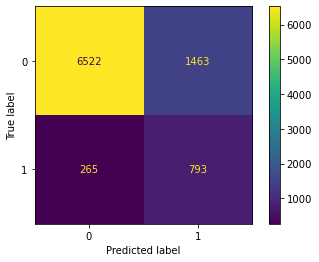

In [453]:
plot_confusion_matrix(rfc_tuned_pipeline,
                     X_test,
                     y_test)

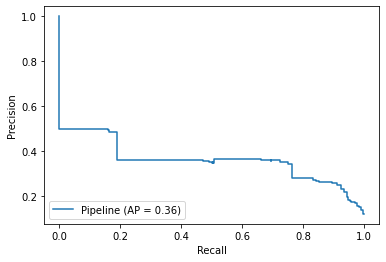

In [454]:
plot_precision_recall_curve(model_tuned_rfc, X_test, y_test)

### __KNN__

#### __A. Pipeline__

In [329]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
numerical_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
#     ('poly', PolynomialFeatures(3, include_bias=False))
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan']),
    ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
knn = KNeighborsClassifier(n_neighbors=5)

knn_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', knn)
])

#### __B. Train and Predict Benchmark Model__

In [330]:
model_default_knn = knn_pipeline.fit(X_train, y_train)
y_pred_default_knn = model_default_knn.predict(X_test)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



#### __C. Evaluation of Benchmark Model__

In [331]:
print(classification_report(y_test, y_pred_default_knn))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      7985
           1       0.23      0.58      0.33      1058

    accuracy                           0.73      9043
   macro avg       0.58      0.66      0.58      9043
weighted avg       0.85      0.73      0.77      9043



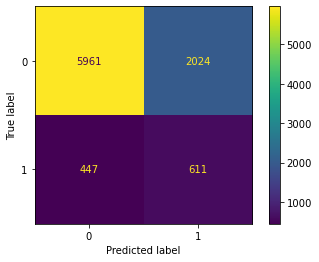

In [332]:
plot_confusion_matrix(knn_pipeline,
                     X_test,
                     y_test)

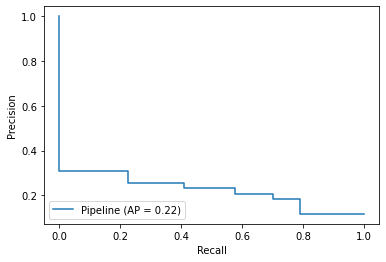

In [333]:
plot_precision_recall_curve(model_default_knn, X_test, y_test)

In [334]:
knn_default_cv = cross_val_score(knn_pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='recall')

In [335]:
print('Mean of KNN Benchmark Model Recall Score: ', knn_default_cv.mean())

Mean of KNN Benchmark Model Recall Score:  0.5859171990700037


#### __D. Hyperparameter Tuning__

In [394]:
param_grid_knn = {'clf__n_neighbors':[5,6,7,8,9,10],
          'clf__leaf_size':[1,2,3,5],
          'clf__weights':['uniform', 'distance']}
#           'clf__algorithm':['auto', 'ball_tree','kd_tree','brute'],

In [395]:
grid_search_knn = GridSearchCV(
    knn_pipeline,
    param_grid = param_grid_knn,
    cv = 2,
    scoring='recall',
    n_jobs=-1,
    verbose = 1
)

In [396]:
grid_search_knn.fit(X_train, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 41.6min finished
D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mode_onehot_pipe',
                                                                         Pipeline(steps=[('mode_impute_cat',
                                                                                          SimpleImputer(missing_values='unknown',
                                                                                                        strategy='most_frequent')),
                                                                                         ('mode_onehot',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['job']),
                                                                     

#### __E. Hyperparameter Tuning Evaluation__

In [397]:
cv_result_knn = pd.DataFrame(grid_search_knn.cv_results_)
cv_result_knn.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__leaf_size,param_clf__n_neighbors,param_clf__weights,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,192.055783,0.659120,3.527488,0.128426,1,5,uniform,"{'clf__leaf_size': 1, 'clf__n_neighbors': 5, '...",0.577305,0.595936,0.586620,0.009315,25
1,197.168356,2.709437,0.879992,0.045475,1,5,distance,"{'clf__leaf_size': 1, 'clf__n_neighbors': 5, '...",0.543262,0.566635,0.554949,0.011686,41
2,195.418365,0.331808,3.086221,0.034982,1,6,uniform,"{'clf__leaf_size': 1, 'clf__n_neighbors': 6, '...",0.533333,0.549149,0.541241,0.007908,45
3,189.376327,0.454238,1.027909,0.100442,1,6,distance,"{'clf__leaf_size': 1, 'clf__n_neighbors': 6, '...",0.556501,0.573251,0.564876,0.008375,37
4,199.118254,0.599154,3.394066,0.028959,1,7,uniform,"{'clf__leaf_size': 1, 'clf__n_neighbors': 7, '...",0.613239,0.631853,0.622546,0.009307,5


In [398]:
mts_list_knn = []

for elm in cv_result_knn['param_clf__n_neighbors'].unique():
    mean_elm = cv_result_knn[cv_result_knn['param_clf__n_neighbors']==elm]['mean_test_score'].mean()
    mts_list_knn.append(mean_elm)

In [399]:
n_neighbors_knn_df = pd.DataFrame({'n_neighbors':cv_result_knn['param_clf__n_neighbors'].unique(),
                                  'test_score':mts_list_knn})

In [400]:
mts_list_knn = []

for elm in cv_result_knn['param_clf__leaf_size'].unique():
    mean_elm = cv_result_knn[cv_result_knn['param_clf__leaf_size']==elm]['mean_test_score'].mean()
    mts_list_knn.append(mean_elm)

In [152]:
leaf_size_knn_df = pd.DataFrame({'leaf_size':cv_result_knn['param_clf__leaf_size'].unique(),
                                  'test_score':mts_list_knn})

In [401]:
mts_list_knn = []

for elm in cv_result_knn['param_clf__weights'].unique():
    mean_elm = cv_result_knn[cv_result_knn['param_clf__weights']==elm]['mean_test_score'].mean()
    mts_list_knn.append(mean_elm)

In [402]:
weights_knn_df = pd.DataFrame({'weights':cv_result_knn['param_clf__weights'].unique(),
                                  'test_score':mts_list_knn})

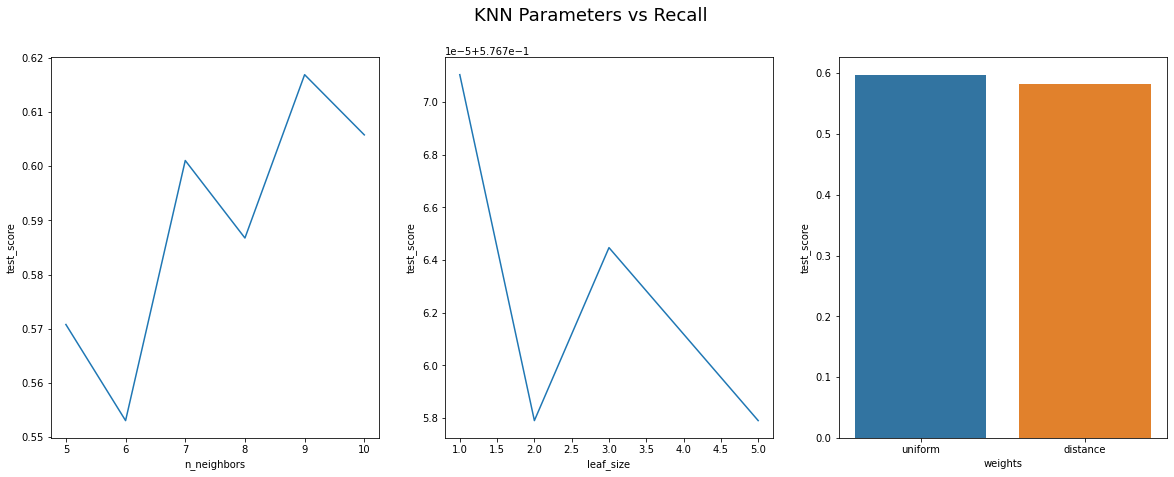

In [403]:
fig, ax = plt.subplots(1,3,figsize=(20,7))
plt.suptitle("KNN Parameters vs Recall", size=18)

sns.lineplot(data=n_neighbors_knn_df, x='n_neighbors', y='test_score', ax=ax[0])
sns.lineplot(data=leaf_size_knn_df, x='leaf_size', y='test_score', ax=ax[1])
sns.barplot(data=weights_knn_df, x='weights', y='test_score', ax=ax[2])

plt.show()

#### __F. Comparing Benchmark Model with Tuned Model__

In [404]:
grid_search_knn.best_params_

{'clf__leaf_size': 1, 'clf__n_neighbors': 9, 'clf__weights': 'uniform'}

In [405]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
numerical_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
#     ('poly', PolynomialFeatures(3, include_bias=False))
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan']),
    ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
knn = KNeighborsClassifier(leaf_size= 1,
                           n_neighbors= 9,
                           weights= 'uniform')

knn_tuned_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', knn)
])

In [406]:
model_tuned_knn = knn_tuned_pipeline.fit(X_train, y_train)
y_pred_tuned_knn = model_tuned_knn.predict(X_test)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [407]:
print(classification_report(y_test, y_pred_tuned_knn))

              precision    recall  f1-score   support

           0       0.94      0.73      0.82      7985
           1       0.24      0.64      0.35      1058

    accuracy                           0.72      9043
   macro avg       0.59      0.69      0.58      9043
weighted avg       0.86      0.72      0.77      9043



__Increasing value of recall from 0.60 to 0.64__

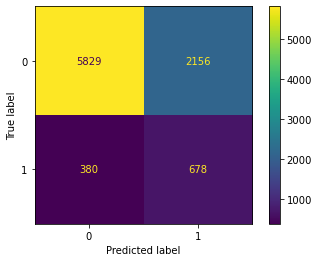

In [408]:
plot_confusion_matrix(knn_tuned_pipeline,
                     X_test,
                     y_test)

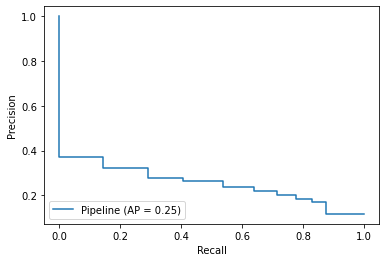

In [409]:
plot_precision_recall_curve(model_tuned_knn, X_test, y_test)

### __Logistic Regression__

#### __A. Pipeline__

In [343]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
numerical_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan']),
    ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
logreg = LogisticRegression(solver='liblinear', random_state=8)

logreg_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', logreg)
])

#### __B. Train and Predict Benchmark Model__

In [344]:
model_default_logreg = logreg_pipeline.fit(X_train, y_train)
y_pred_default_logreg = model_default_logreg.predict(X_test)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



#### __C. Evaluation of Benchmark Model__

In [345]:
print(classification_report(y_test, y_pred_default_logreg))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      7985
           1       0.33      0.80      0.47      1058

    accuracy                           0.79      9043
   macro avg       0.65      0.79      0.67      9043
weighted avg       0.89      0.79      0.82      9043



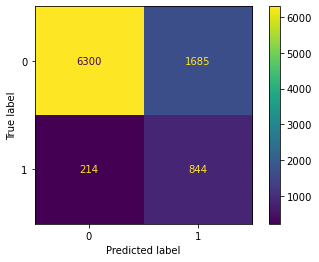

In [346]:
plot_confusion_matrix(logreg_pipeline,
                     X_test,
                     y_test)

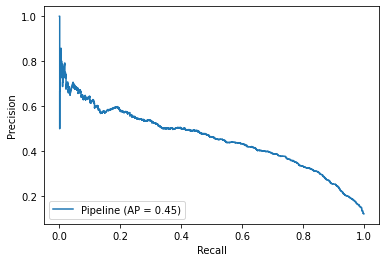

In [347]:
plot_precision_recall_curve(model_default_logreg, X_test, y_test)

In [348]:
logreg_default_cv = cross_val_score(logreg_pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='recall')

In [349]:
print("Mean of Logistic Regression Benchmark Model Recall Score: ", logreg_default_cv.mean())

Mean of Logistic Regression Benchmark Model Recall Score:  0.7780655407347863


#### __D. Hyperparameter Tuning__

In [370]:
hyperparam_space_logreg = {
     'clf__C':[1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # benck mark 1 C = 1 bench mark 2 C = 0.05
    'clf__penalty':['l1', 'l2']
}

In [371]:
grid_search_logreg = GridSearchCV(
    logreg_pipeline,
    param_grid = hyperparam_space_logreg,
    cv = 2,
    scoring='recall',
    n_jobs=-1,
    verbose = 1
)

In [372]:
grid_search_logreg.fit(X_train, y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 25.4min finished
D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mode_onehot_pipe',
                                                                         Pipeline(steps=[('mode_impute_cat',
                                                                                          SimpleImputer(missing_values='unknown',
                                                                                                        strategy='most_frequent')),
                                                                                         ('mode_onehot',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['job']),
                                                                     

#### __E. Hyperparameter Tuning Evaluation__

In [375]:
print('best score', grid_search_logreg.best_score_)
print('best params', grid_search_logreg.best_params_)

best score 0.9825084798026518
best params {'clf__C': 0.0001, 'clf__penalty': 'l1'}


In [376]:
cv_result_logreg = pd.DataFrame(grid_search_logreg.cv_results_)
cv_result_logreg.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,194.409736,3.078225,0.395271,0.178398,1000,l1,"{'clf__C': 1000, 'clf__penalty': 'l1'}",0.786761,0.757561,0.772161,0.014600,22
1,198.669778,2.643975,0.298328,0.089448,1000,l2,"{'clf__C': 1000, 'clf__penalty': 'l2'}",0.784870,0.765123,0.774996,0.009874,8
2,203.064696,8.295167,0.223408,0.004536,500,l1,"{'clf__C': 500, 'clf__penalty': 'l1'}",0.786761,0.757561,0.772161,0.014600,22
3,201.842380,5.147963,0.295877,0.039930,500,l2,"{'clf__C': 500, 'clf__penalty': 'l2'}",0.784870,0.765123,0.774996,0.009874,8
4,196.826060,1.544110,0.210878,0.016989,100,l1,"{'clf__C': 100, 'clf__penalty': 'l1'}",0.786761,0.757561,0.772161,0.014600,22


In [378]:
mts_list_c = []

for elm in cv_result_logreg['param_clf__C'].unique():
    mean_elm = cv_result_logreg[cv_result_logreg['param_clf__C']==elm]['mean_test_score'].mean()
    mts_list_c.append(mean_elm)

In [379]:
c_logreg_df = pd.DataFrame({'C':cv_result_logreg['param_clf__C'].unique(),
                           'test_score':mts_list_c})

In [381]:
mts_list_penalty = []

for elm in cv_result_logreg['param_clf__penalty'].unique():
    mean_elm = cv_result_logreg[cv_result_logreg['param_clf__penalty']==elm]['mean_test_score'].mean()
    mts_list_penalty.append(mean_elm)

In [382]:
penalty_logreg_df = pd.DataFrame({'penalty':cv_result_logreg['param_clf__penalty'].unique(),
                           'test_score':mts_list_penalty})

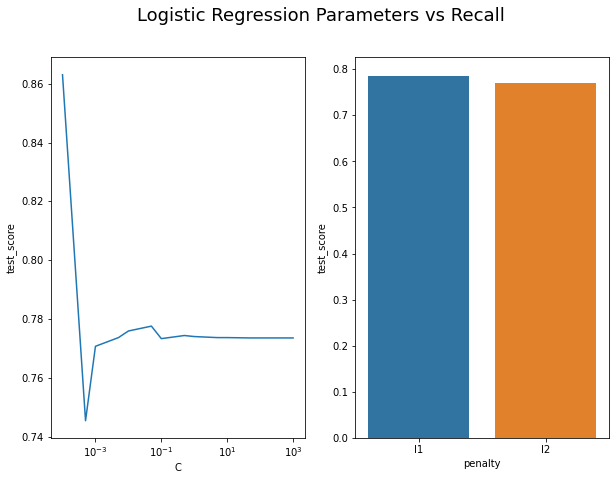

In [385]:
fig, ax = plt.subplots(1,2,figsize=(10,7))
plt.suptitle("Logistic Regression Parameters vs Recall", size=18)

sns.lineplot(data=c_logreg_df, x='C', y='test_score', ax=ax[0])
ax[0].set_xscale('log')

sns.barplot(data=penalty_logreg_df, x='penalty', y='test_score', ax=ax[1])
plt.show()

#### __F. Comparing Benchmark and Tuned Model__

In [386]:
grid_search_logreg.best_params_

{'clf__C': 0.0001, 'clf__penalty': 'l1'}

In [389]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
numerical_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan']),
    ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
logreg = LogisticRegression(C= 0.0001,
                            penalty='l1',
                            solver='liblinear',
                            random_state=8)

logreg_tuned_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', logreg)
])

In [390]:
model_tuned_logreg = logreg_tuned_pipeline.fit(X_train, y_train)
y_pred_tuned_logreg = model_tuned_logreg.predict(X_test)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [391]:
print(classification_report(y_test, y_pred_tuned_logreg))

              precision    recall  f1-score   support

           0       0.97      0.44      0.60      7985
           1       0.17      0.88      0.29      1058

    accuracy                           0.49      9043
   macro avg       0.57      0.66      0.45      9043
weighted avg       0.87      0.49      0.57      9043



__Increase value of recall from 0.78 to 0.79.__

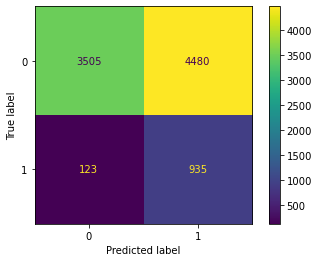

In [392]:
plot_confusion_matrix(logreg_tuned_pipeline,
                     X_test,
                     y_test)

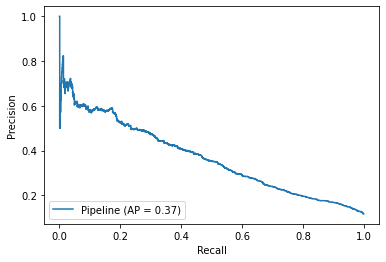

In [393]:
plot_precision_recall_curve(model_tuned_logreg, X_test, y_test)

### __SVM__

#### __A. Pipeline__

In [81]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
numerical_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan']),
    ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
svc = SVC(random_state=8, probability=True, C=10)

svm_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', svc)
])

#### __B. Benchmark Model Train and Predict__

In [351]:
model_default_svm = svm_pipeline.fit(X_train, y_train)
y_pred_default_svm = model_default_svm.predict(X_test)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



#### __C. Benchmark Model Evaluation__

In [352]:
print(classification_report(y_test, y_pred_default_svm))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85      7985
           1       0.29      0.70      0.41      1058

    accuracy                           0.76      9043
   macro avg       0.62      0.74      0.63      9043
weighted avg       0.87      0.76      0.80      9043



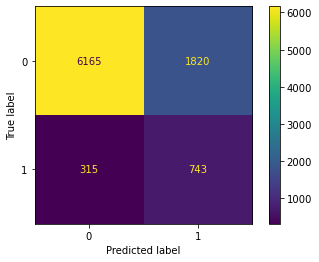

In [353]:
plot_confusion_matrix(svm_pipeline,
                     X_test,
                     y_test)

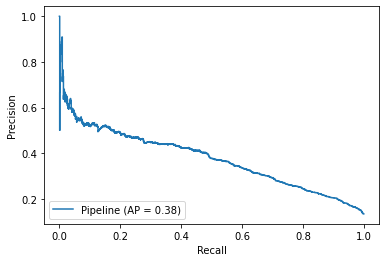

In [354]:
plot_precision_recall_curve(model_default_svm, X_test, y_test)

#### __D. Hyperparameter Tuning__

In [188]:
param_grid_svm = {'clf__C': [0.1,1, 10, 100], 
                  'clf__gamma': [1,0.1,0.01,0.001],
                  'clf__kernel': ['rbf'], 
                  'clf__degree': [5,6,7]}

In [189]:
grid_search_svm = GridSearchCV(
    svm_pipeline,
    param_grid = param_grid_svm,
    cv = 2,
    scoring='recall',
    n_jobs=-1,
    verbose = 1
)

In [190]:
grid_search_svm.fit(X_train, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 121.6min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 443.2min finished
D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mode_onehot_pipe',
                                                                         Pipeline(steps=[('mode_impute_cat',
                                                                                          SimpleImputer(missing_values='unknown',
                                                                                                        strategy='most_frequent')),
                                                                                         ('mode_onehot',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['job']),
                                                                     

#### __E. Hyperparameter Tuning Evaluation__

In [191]:
cv_result_svm = pd.DataFrame(grid_search_svm.cv_results_)
cv_result_svm.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__degree,param_clf__gamma,param_clf__kernel,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,1218.298274,18.238723,86.982244,7.472290,0.1,1,1,rbf,"{'clf__C': 0.1, 'clf__degree': 1, 'clf__gamma'...",0.000631,0.003151,0.001891,0.001260,46
1,1193.598773,28.300299,82.455885,0.821032,0.1,1,0.100,rbf,"{'clf__C': 0.1, 'clf__degree': 1, 'clf__gamma'...",0.986129,0.982987,0.984558,0.001571,1
2,1169.831120,11.913467,77.291542,2.786351,0.1,1,0.010,rbf,"{'clf__C': 0.1, 'clf__degree': 1, 'clf__gamma'...",0.861917,0.869565,0.865741,0.003824,4
3,964.462479,7.558025,54.672860,2.528857,0.1,1,0.001,rbf,"{'clf__C': 0.1, 'clf__degree': 1, 'clf__gamma'...",0.772383,0.792060,0.782222,0.009839,7
4,1139.801203,4.323484,82.343288,1.695440,0.1,2,1,rbf,"{'clf__C': 0.1, 'clf__degree': 2, 'clf__gamma'...",0.000631,0.003151,0.001891,0.001260,46


In [192]:
cv_result_svm[cv_result_svm['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__degree,param_clf__gamma,param_clf__kernel,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
1,1193.598773,28.300299,82.455885,0.821032,0.1,1,0.1,rbf,"{'clf__C': 0.1, 'clf__degree': 1, 'clf__gamma'...",0.986129,0.982987,0.984558,0.001571,1
5,1106.820405,10.163587,77.380555,2.304903,0.1,2,0.1,rbf,"{'clf__C': 0.1, 'clf__degree': 2, 'clf__gamma'...",0.986129,0.982987,0.984558,0.001571,1
9,1081.201725,2.004212,76.742738,1.170813,0.1,3,0.1,rbf,"{'clf__C': 0.1, 'clf__degree': 3, 'clf__gamma'...",0.986129,0.982987,0.984558,0.001571,1


In [222]:
mts_list_c = []

for elm in cv_result_svm['param_clf__C'].unique():
    mean_elm = cv_result_svm[cv_result_svm['param_clf__C']==elm]['mean_test_score'].mean()
    mts_list_c.append(mean_elm)

In [223]:
mts_list_degree = []

for elm in cv_result_svm['param_clf__degree'].unique():
    mean_elm = cv_result_svm[cv_result_svm['param_clf__degree']==elm]['mean_test_score'].mean()
    mts_list_degree.append(mean_elm)

In [224]:
mts_list_gamma= []

for elm in cv_result_svm['param_clf__gamma'].unique():
    mean_elm = cv_result_svm[cv_result_svm['param_clf__gamma']==elm]['mean_test_score'].mean()
    mts_list_gamma.append(mean_elm)

In [225]:
mts_list_kernel= []

for elm in cv_result_svm['param_clf__kernel'].unique():
    mean_elm = cv_result_svm[cv_result_svm['param_clf__kernel']==elm]['mean_test_score'].mean()
    mts_list_kernel.append(mean_elm)

In [226]:
c_svm_df = pd.DataFrame({'C':cv_result_svm['param_clf__C'].unique(),
                           'test_score':mts_list_c})

In [230]:
degree_svm_df = pd.DataFrame({'degree':cv_result_svm['param_clf__degree'].unique(),
                           'test_score':mts_list_degree})

In [231]:
gamma_svm_df = pd.DataFrame({'gamma':cv_result_svm['param_clf__gamma'].unique(),
                           'test_score':mts_list_gamma})

In [240]:
kernel_svm_df = pd.DataFrame({'kernel':cv_result_svm['param_clf__kernel'].unique(),
                           'test_score':mts_list_kernel})

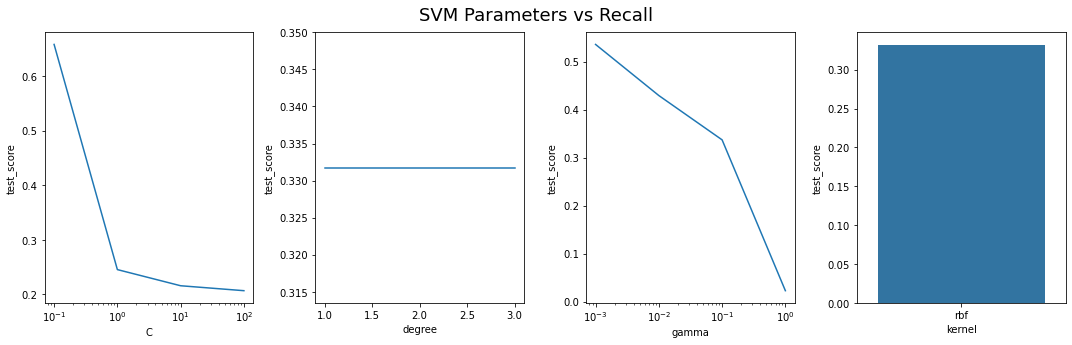

In [263]:
fig, ax = plt.subplots(1,4,figsize=(15,5))
plt.suptitle("SVM Parameters vs Recall", size=18)

sns.lineplot(data=c_svm_df, x='C', y='test_score', ax=ax[0])
ax[0].set_xscale('log')

sns.lineplot(data=degree_svm_df, x='degree', y='test_score', ax=ax[1])
sns.lineplot(data=gamma_svm_df, x='gamma', y='test_score', ax=ax[2])
ax[2].set_xscale('log')

sns.barplot(data=kernel_svm_df, x='kernel', y='test_score', ax=ax[3])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### __F. Comparing Benchmark and Tuned Model__

In [264]:
grid_search_svm.best_params_

{'clf__C': 0.1, 'clf__degree': 1, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}

In [549]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
numerical_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
#     ('poly', PolynomialFeatures(3, include_bias=False))
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan']),
    ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
svc = SVC(C= 0.1,
          degree= 1,
          gamma= 0.1,
          kernel= 'rbf',
          probability=True)

svm_tuned_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', svc)
])

In [289]:
model_tuned_svm = svm_tuned_pipeline.fit(X_train, y_train)
y_pred_tuned_svm = model_tuned_svm.predict(X_test)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [290]:
print(classification_report(y_test, y_pred_tuned_svm))

              precision    recall  f1-score   support

           0       0.97      0.09      0.16      7985
           1       0.12      0.98      0.22      1058

    accuracy                           0.19      9043
   macro avg       0.55      0.53      0.19      9043
weighted avg       0.87      0.19      0.17      9043



__Recall is almost perfect. Very high increase from benchmark model.__

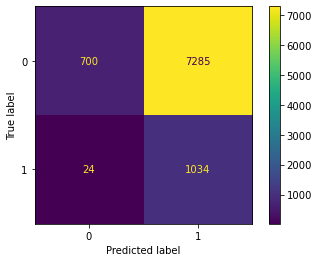

In [291]:
plot_confusion_matrix(svm_tuned_pipeline,
                     X_test,
                     y_test)

__Very high recall score but so many false negative values. But, this confusion matrix is only based from threshold=0.5. To see how good the model is as a whole, we need to see the precision recall curve for this model.__

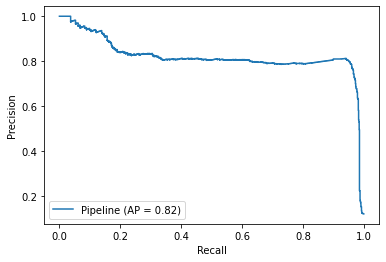

In [507]:
plot_precision_recall_curve(model_tuned_svm, X_test, y_test)
plt.show()

__As we can see, this model has very good precision recall curve with high PR AUC. Also, it is stable at almost all kind of thresholds. But, using threshold that resulting in recall score exceeds 0.9 is not recommended as it will decrease the value of precision very significantly.__

### __Gradient Boosting__

In [356]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan'])
#     ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
gboost = GradientBoostingClassifier(random_state=8)

gb_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', gboost)
])

In [357]:
model_default_gb = gb_pipeline.fit(X_train, y_train)
y_pred_default_gb = model_default_gb.predict(X_test)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [358]:
print(classification_report(y_test, y_pred_default_gb))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7985
           1       0.53      0.52      0.52      1058

    accuracy                           0.89      9043
   macro avg       0.73      0.73      0.73      9043
weighted avg       0.89      0.89      0.89      9043



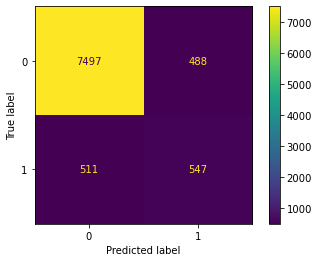

In [359]:
plot_confusion_matrix(gb_pipeline,
                     X_test,
                     y_test)

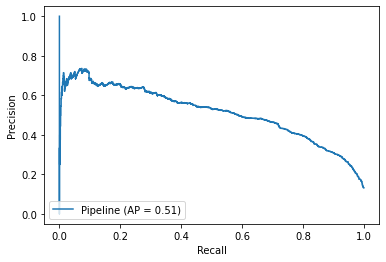

In [361]:
plot_precision_recall_curve(model_default_gb, X_test, y_test)

In [362]:
gb_default_cv = cross_val_score(gb_pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='recall')

In [364]:
print("Mean of Gradient Boosting Benchmark Model Recall Score: ", gb_default_cv.mean())

Mean of Gradient Boosting Benchmark Model Recall Score:  0.5062579372057128


In [365]:
param_grid_gb = {
    "clf__n_estimators":[5,50,250,500],
    "clf__max_depth":[1,3,5,7,9],
    "clf__learning_rate":[0.01,0.1,1,10,100]
}

In [366]:
grid_search_gb = GridSearchCV(
    gb_pipeline,
    param_grid = param_grid_gb,
    cv = 2,
    scoring='recall',
    n_jobs=-1,
    verbose = 1
)

In [367]:
grid_search_gb.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 110.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 119.7min finished
D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mode_onehot_pipe',
                                                                         Pipeline(steps=[('mode_impute_cat',
                                                                                          SimpleImputer(missing_values='unknown',
                                                                                                        strategy='most_frequent')),
                                                                                         ('mode_onehot',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['job']),
                                                                     

In [368]:
cv_result_gb = pd.DataFrame(grid_search_gb.cv_results_)
cv_result_gb.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,199.776936,7.549301,0.214376,0.007496,0.01,1,5,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.809456,0.829395,0.819426,0.009969,9
1,210.275087,3.968215,0.260350,0.009495,0.01,1,50,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.792435,0.791115,0.791775,0.000660,11
2,216.104247,3.121224,0.310321,0.003499,0.01,1,250,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.740426,0.725898,0.733162,0.007264,20
3,227.519191,0.794044,0.373783,0.002996,0.01,1,500,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.747045,0.713138,0.730091,0.016953,22
4,184.167534,3.452356,0.219374,0.017489,0.01,3,5,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.781087,0.694234,0.737661,0.043427,18


In [369]:
cv_result_gb[cv_result_gb['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
80,240.601313,1.691020,0.227365,0.008491,100,1,5,"{'clf__learning_rate': 100, 'clf__max_depth': ...",1.0,1.0,1.0,0.0,1
81,219.038636,0.313833,0.240861,0.012993,100,1,50,"{'clf__learning_rate': 100, 'clf__max_depth': ...",1.0,1.0,1.0,0.0,1
82,226.248772,2.362638,0.444743,0.134923,100,1,250,"{'clf__learning_rate': 100, 'clf__max_depth': ...",1.0,1.0,1.0,0.0,1
83,246.089941,4.685372,0.406266,0.001500,100,1,500,"{'clf__learning_rate': 100, 'clf__max_depth': ...",1.0,1.0,1.0,0.0,1


In [455]:
mts_list_learning_rate_gb = []

for elm in cv_result_gb['param_clf__learning_rate'].unique():
    mean_elm = cv_result_gb[cv_result_gb['param_clf__learning_rate']==elm]['mean_test_score'].mean()
    mts_list_learning_rate_gb.append(mean_elm)

In [456]:
mts_list_max_depth_gb = []

for elm in cv_result_gb['param_clf__max_depth'].unique():
    mean_elm = cv_result_gb[cv_result_gb['param_clf__max_depth']==elm]['mean_test_score'].mean()
    mts_list_max_depth_gb.append(mean_elm)

In [457]:
mts_list_n_estimators_gb = []

for elm in cv_result_gb['param_clf__n_estimators'].unique():
    mean_elm = cv_result_gb[cv_result_gb['param_clf__n_estimators']==elm]['mean_test_score'].mean()
    mts_list_n_estimators_gb.append(mean_elm)

In [458]:
learning_rate_gb_df = pd.DataFrame({'learning_rate':cv_result_gb['param_clf__learning_rate'].unique(),
                           'test_score':mts_list_learning_rate_gb})

In [459]:
max_depth_gb_df = pd.DataFrame({'max_depth':cv_result_gb['param_clf__max_depth'].unique(),
                           'test_score':mts_list_max_depth_gb})

In [460]:
n_estimators_gb_df = pd.DataFrame({'n_estimators':cv_result_gb['param_clf__n_estimators'].unique(),
                           'test_score':mts_list_n_estimators_gb})

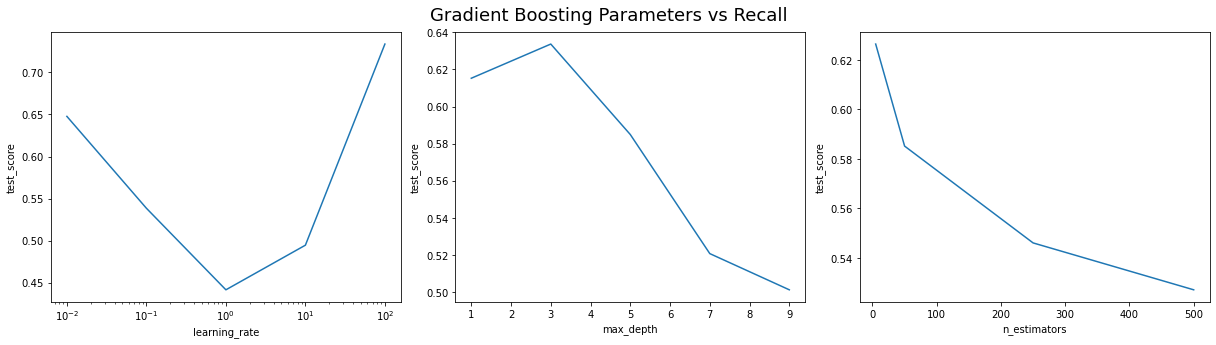

In [461]:
fig, ax = plt.subplots(1,3,figsize=(17,5))
plt.suptitle("Gradient Boosting Parameters vs Recall", size=18)

sns.lineplot(data=learning_rate_gb_df , x='learning_rate', y='test_score', ax=ax[0])
ax[0].set_xscale('log')

sns.lineplot(data=max_depth_gb_df, x='max_depth', y='test_score', ax=ax[1])
sns.lineplot(data=n_estimators_gb_df , x='n_estimators', y='test_score', ax=ax[2])
# ax[2].set_xscale('log')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### __F. Comparing Benchmark and Tuned Model__

In [478]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
gboost = GradientBoostingClassifier(learning_rate= 0.001, max_depth= 3, n_estimators= 5, random_state=8)

gb_tuned_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', gboost)
])

In [479]:
model_tuned_gb = gb_tuned_pipeline.fit(X_train, y_train)
y_pred_tuned_gb = model_tuned_gb.predict(X_test)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [480]:
print(classification_report(y_test, y_pred_tuned_gb))

              precision    recall  f1-score   support

           0       0.96      0.72      0.83      7985
           1       0.28      0.80      0.41      1058

    accuracy                           0.73      9043
   macro avg       0.62      0.76      0.62      9043
weighted avg       0.88      0.73      0.78      9043



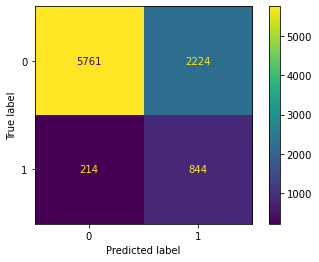

In [481]:
plot_confusion_matrix(gb_tuned_pipeline,
                     X_test,
                     y_test)

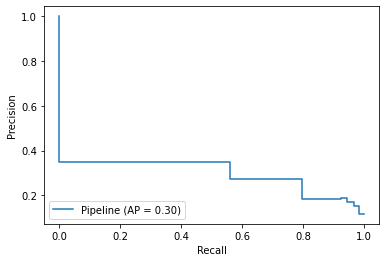

In [482]:
plot_precision_recall_curve(model_tuned_gb, X_test, y_test)

## __Comparison Betweeen Tuned Models__

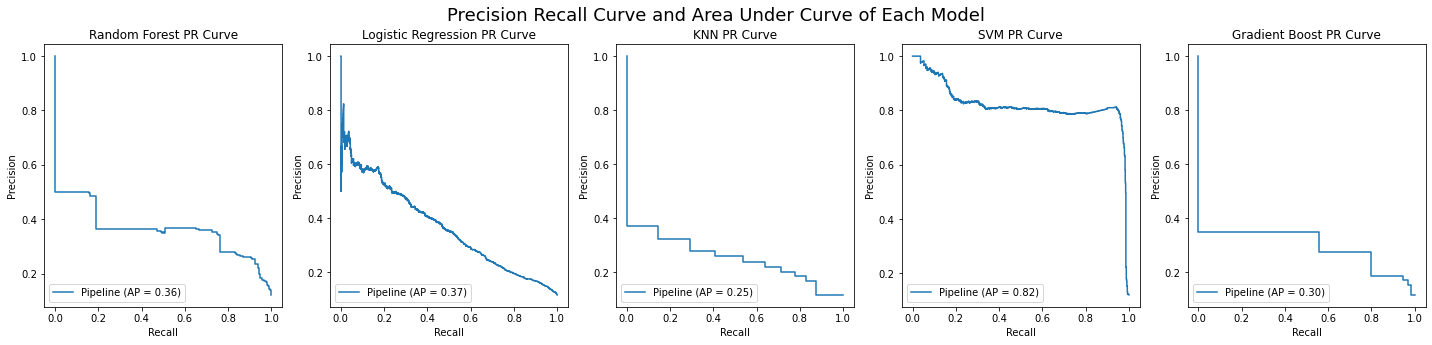

In [489]:
fig, ax = plt.subplots(1,5, figsize=(20, 5))
plt.suptitle("Precision Recall Curve and Area Under Curve of Each Model", size=18)

plot_precision_recall_curve(model_tuned_rfc, X_test, y_test, ax=ax[0])
ax[0].set_title("Random Forest PR Curve")

plot_precision_recall_curve(model_tuned_logreg, X_test, y_test, ax=ax[1])
ax[1].set_title("Logistic Regression PR Curve")

plot_precision_recall_curve(model_tuned_knn, X_test, y_test, ax=ax[2])
ax[2].set_title("KNN PR Curve")

plot_precision_recall_curve(model_tuned_svm, X_test, y_test, ax=ax[3])
ax[3].set_title("SVM PR Curve")

plot_precision_recall_curve(model_tuned_gb, X_test, y_test, ax=ax[4])
ax[4].set_title("Gradient Boost PR Curve")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

__It could be seen from the AUC value that SVM model is the best between 5 models. It also provides the best trade off between precision and recall for all thresholds. But still, the best threshold still has to be decided so the best trade off between precision and recall could be determined.__

## __Determining the Best Threshold for Tuned SVM Model__

__For this problem, the main focus of the scoring is Recall because we have to maximize the True Positive and reduce False Negaive as much as possible without sacrificing too much on the Precision. From the plot of SVM PR Curve, we could see that the best Recall and Precision trade off is around Recall=0.9 and Precision=0.8. So, we need to determine the threshold for that trade off to maximize the performance of the model.__

#### __1. Fit All Data with Best Model (SVM)__

In [ ]:
model_tuned_svm_final = svm_tuned_pipeline.fit(X, y)

#### __2. Create Dataframe of Precision, Recall, and Threhold from PR Curve of Tuned SVM Model__

In [ ]:
prob_tuned_svm_final = model_tuned_svm_final.predict_proba(X)[:,1]
precision_svm_tuned_final, recall_svm_tuned_final, thresholds_svm_tuned_final = precision_recall_curve(y, prob_tuned_svm_final)
pr_svm_tuned_final_df = pd.DataFrame({'precision': precision_svm_tuned_final[:-1], 'recall': recall_svm_tuned_final[:-1], 'thr': thresholds_svm_tuned_final})

In [514]:
pr_svm_tuned_final_df

,precision,recall,thr
0,0.117455,1.000000,0.000012
1,0.117435,0.999811,0.000012
2,0.117438,0.999811,0.000012
3,0.117441,0.999811,0.000012
4,0.117443,0.999811,0.000012
...,...,...,...
42528,0.400000,0.000378,0.987125
42529,0.250000,0.000189,0.987757
42530,0.333333,0.000189,0.989189
42531,0.500000,0.000189,0.990013


https://stackoverflow.com/questions/31639016/in-scikits-precision-recall-curve-why-does-thresholds-have-a-different-dimensi

#### __3. Plot Precision and Recall vs Threshold__

In [527]:
def plot_precision_recall_vs_threshold(precisions, recall, thresholds): 
    fig = plt.figure(figsize= (8,5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.axvline(x=0.58, label="Best Threshold", color='red', linestyle='dashdot')
    plt.legend(loc=4)

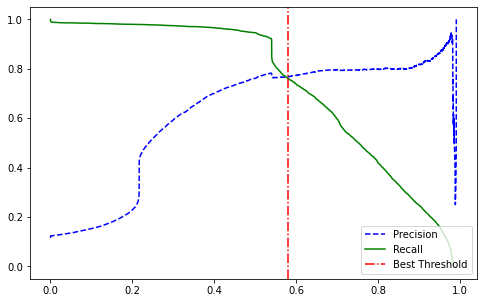

In [528]:
plot_precision_recall_vs_threshold(precision_svm_tuned_final, recall_svm_tuned_final, thresholds_svm_tuned_final)

__It could be concluded from the graph that the best threshold for best trade off between precision and recall for this model is 0.58. But, this is not a mandatory as better threshold for better recall still could be picked without losing too much precision. For this project, threshold=0.58 will be implemented at deployment.__

## __Save Model with Joblib__

In [530]:
joblib.dump(model_tuned_svm_final, 'svm_model_final')

['svm_model_final']

In [531]:
model_test = joblib.load('svm_model_final')
model_test

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mode_onehot_pipe',
                                                  Pipeline(steps=[('mode_impute_cat',
                                                                   SimpleImputer(missing_values='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('mode_onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['job']),
                                                 ('mode_ordinal_pipe',
                                                  Pipeline(steps=[('mode_ordinal_cat',
                                                                   SimpleImputer(missing_values='...
                                    

## __Prediction Test__

In [569]:
data_input=[[14, 'admin.', 'married', 'primary', 'yes', 1113, 'no', 'yes', 'cellular', 12, 12, 3, 2]]

df_test = pd.DataFrame(data_input, columns = X.columns)

In [570]:
df_test

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous
0,14,admin.,married,primary,yes,1113,no,yes,cellular,12,12,3,2


In [571]:
pred_test = model_test.predict(df_test)

In [572]:
pred_test

array([1])